# 0. 라이브러리 설치

In [ ]:
%pip install ipykernal
%pip install librosa
%pip install numpy
%pip install noisereduce
%pip install matplotlib
%pip install sklearn
%pip install pickle

In [1]:
import librosa
import numpy as np
import noisereduce as nr
import sklearn.preprocessing
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import pickle

c:\Users\GAILAB\anaconda3\envs\fmcc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. 데이터 전처리 함수 정의

In [2]:
# Make avg_frame length for same input
def zero_padding(mfcc, avg_frame=40):
    if mfcc.shape[1] < avg_frame:
        padding = np.zeros((mfcc.shape[0], avg_frame - mfcc.shape[1]))
        mfcc = np.hstack((mfcc, padding))
    else:
        mfcc = mfcc[:, :avg_frame]
        
    return mfcc

# raw-to-mfcc
def raw_to_mfcc(raw_file_path):

    # Read raw file
    with open(raw_file_path, 'rb') as file:
        # Raw-to-wav
        audio_data = np.frombuffer(file.read(), dtype=np.int16)
        audio_data = audio_data.astype(np.float32)

    # Reduce noise
    clean_data = nr.reduce_noise(y=audio_data, sr=16000)

    # Wav-to-mfcc
    mfcc = librosa.feature.mfcc(y=clean_data, sr=16000, n_mfcc=20, n_mels=100, fmin=0, fmax=400)

    # Zero padding and scaling
    mfcc = zero_padding(mfcc, avg_frame=37)
    mfcc = sklearn.preprocessing.minmax_scale(mfcc, axis=1)

    # Flatten data for model input
    mfcc = mfcc.flatten()

    return mfcc

# 2. Train 데이터 전처리

In [4]:
train_data = []
train_label = []

avg = 0

with open('fmcc_train.ctl', 'r') as file:
    for line in tqdm(file):
        file_path = './raw16k/train/' + line.rstrip() + '.raw'
        train_label.append(line[0])
        train_data.append(raw_to_mfcc(file_path))

        avg += raw_to_mfcc(file_path).shape[1]

train_data = [data.flatten() for data in train_data]
train_label = np.array(train_label)

8000it [08:54, 14.96it/s]


# 3. Test 전처리

In [6]:
test_data = []
test_data_name = []

wav_length = 0

with open('fmcc_test.ctl', 'r') as file:
    for line in tqdm(file):
        file_path = './raw16k/test/' + line.rstrip() + '.raw'
        
        test_data_name.append(file_path)

        mfcc = raw_to_mfcc(file_path)
        test_data.append(mfcc)

1000it [00:28, 35.58it/s]


# Legacy

## 일단 무시

In [7]:
np.save('test_data.npy', test_data)

In [6]:
np.save('train_data.npy', train_data)
np.save('train_label.npy', train_label)
np.save('test_data.npy', test_data)

In [ ]:
test_data = []
test_data_name = []

with open('fmcc_test.ctl', 'r') as file:
    for line in tqdm(file):
        file_path = './raw16k/test/' + line.rstrip() + '.raw'
        
        test_data_name.append(file_path)
        #test_data.append(raw_to_mfcc(file_path))

#test_data = [data.flatten() for data in test_data]

In [8]:
X_train = np.load('train_data.npy')
Y_train = np.load('train_label.npy')
X_test = np.load('test_data.npy')
Y_test = np.load('test_label.npy')

In [4]:
test_label = []

with open('fmcc_test_ref.txt', 'r') as file:
    for line in file:
        label = line.split(' ')[1][0].upper()
        test_label.append(label)

test_label = np.array(test_label)
np.save('test_label.npy', test_label)

## zero padding 전처리 데이터 저장

In [92]:
np.save('train_data_zp.npy', train_data)
np.save('test_data_zp.npy', test_data)

In [93]:
X_train = np.load('train_data_zp.npy')
Y_train = np.load('train_label.npy')
X_test = np.load('test_data_zp.npy')

print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(8000, 520)


## Legacy Index Shuffle

In [6]:
idx = np.arange(len(X_train))
np.random.shuffle(idx)
X_train = X_train[idx]
Y_train = Y_train[idx]

# 4. SVM 정의 / 학습 / 예측

In [9]:
# Create an instance of the SVM classifier
svm_classifier = SVC()

svm_classifier.fit(X_train, Y_train)

# Predict the classes for the preprocessed_data
predict = svm_classifier.predict(X_test)

# 5. result 파일 저장

In [10]:
file = open('./과탑_test_results.txt', 'w')

for i in range(len(predict)):
    if predict[i] == 'M':
        res = 'male'
    else:
        res = 'feml'

    file.write(test_data_name[i] + ' ' + res + '\n')
file.close()

In [97]:
with open('zp_svc_model.pkl', 'wb') as f:
    pickle.dump(svm_classifier, f)

In [98]:
with open('zp_svc_model.pkl', 'rb') as f:
    loaded_svc = pickle.load(f)

# 실행 X Plotting Learning curve

In [4]:
# Create SVM, KNN and Random Forest classifiers
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier(n_neighbors=13)
rf = RandomForestClassifier(
    min_samples_leaf=5,
    min_samples_split=7,
    max_depth=17,
    criterion='gini',
    max_features='log2',
    bootstrap=False,
    random_state=42
)

# Create a voting classifier
voting_classifier = VotingClassifier(
    estimators=[('svm', svm_classifier),
                ('knn', knn_classifier),
                ('rf', rf)],
    voting='hard'
)

In [9]:
import matplotlib.pyplot as plt

# Shuffle the data
idx = np.arange(len(X_train))
np.random.shuffle(idx)
X_train_shuffled = X_train[idx]
Y_train_shuffled = Y_train[idx]

# Train data splits
train_data_splits = []
train_label_splits = []

split_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for split_percentage in split_percentages:
    split_index = int(len(X_train_shuffled) * split_percentage)
    train_data_splits.append(X_train_shuffled[:split_index])
    train_label_splits.append(Y_train_shuffled[:split_index])

# Create test scores list
test_scores = []

# Create a list of SVM classifiers
svm_classifier_list = [voting_classifier for _ in range(10)]

# Train the SVM classifiers
for i in tqdm(range(len(svm_classifier_list))):
    svm_classifier_list[i].fit(train_data_splits[i], train_label_splits[i])

    # Test the SVM classifiers
    test_scores.append(svm_classifier_list[i].score(X_test, Y_test))

100%|██████████| 10/10 [01:29<00:00,  9.00s/it]


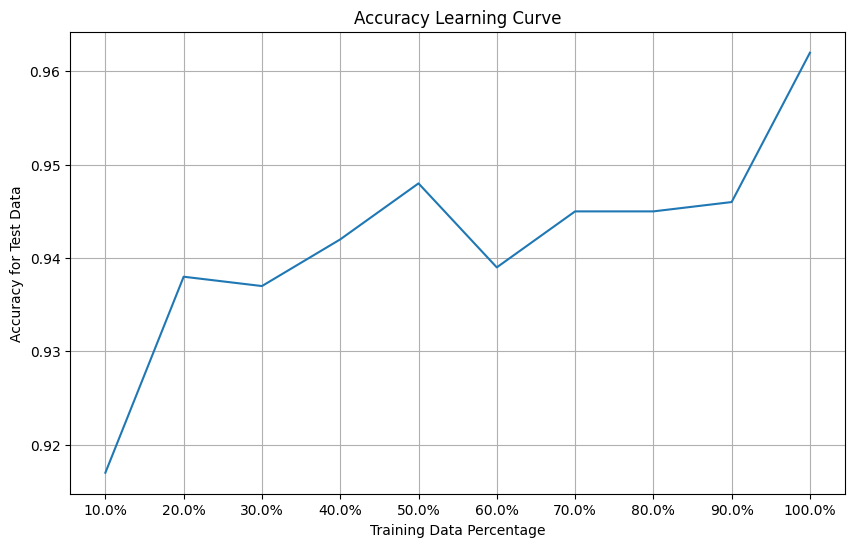

In [10]:
plt.figure(figsize=(10, 6))
data_percentage = [str(split_percentage*100)+'%' for split_percentage in split_percentages]

plt.plot(data_percentage, test_scores)
plt.title('Accuracy Learning Curve')
plt.xlabel('Training Data Percentage')
plt.ylabel('Accuracy for Test Data')
plt.grid()

plt.show()

# Ensemble

In [43]:
from sklearn.ensemble import BaggingClassifier

In [44]:
base_svm = SVC(verbose=True)
svm_bag = BaggingClassifier(base_svm, max_samples=0.8, n_estimators=10, verbose=3)
svm_bag.fit(X_train, Y_train)

predict = svm_bag.predict(X_test)

Building estimator 1 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 2 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 3 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 4 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 5 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 6 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 7 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 8 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 9 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 10 of 10 for this parallel run (total 10)...
[LibSVM]

In [45]:
file = open('./bag_test_results.txt', 'w')

for i in range(len(predict)):
    if predict[i] == 'M':
        res = 'male'
    else:
        res = 'feml'

    file.write(test_data_name[i] + ' ' + res + '\n')
file.close()

94.2

In [39]:
rand = list(np.random.randint(low=0, high=100, size=10))
print(rand)

[96, 27, 10, 17, 41, 31, 98, 27, 61, 39]


In [40]:
from sklearn.ensemble import VotingClassifier

state_list = list(rand)
svm_list = [SVC(random_state=state) for state in state_list]

voting_svm = VotingClassifier(estimators=[('svm_'+str(i), svm) for i, svm in enumerate(svm_list)], voting='hard', verbose=True)
voting_svm.fit(X_train, Y_train)

predict = voting_svm.predict(X_test)

[Voting] ................... (1 of 10) Processing svm_0, total=   5.1s
[Voting] ................... (2 of 10) Processing svm_1, total=   5.4s
[Voting] ................... (3 of 10) Processing svm_2, total=   5.9s
[Voting] ................... (4 of 10) Processing svm_3, total=   5.5s
[Voting] ................... (5 of 10) Processing svm_4, total=   5.6s
[Voting] ................... (6 of 10) Processing svm_5, total=   5.7s
[Voting] ................... (7 of 10) Processing svm_6, total=   5.6s
[Voting] ................... (8 of 10) Processing svm_7, total=   5.9s
[Voting] ................... (9 of 10) Processing svm_8, total=   5.6s
[Voting] .................. (10 of 10) Processing svm_9, total=   5.4s


In [41]:
file = open('./vote_test_results.txt', 'w')

for i in range(len(predict)):
    if predict[i] == 'M':
        res = 'male'
    else:
        res = 'feml'

    file.write(test_data_name[i] + ' ' + res + '\n')
file.close()

93

In [13]:
from sklearn.ensemble import VotingClassifier

C_list = [0.01, 0.1, 1, 0.01, 0.1, 1, 0.01, 0.1, 1, 0.01]
state_list = [39, 98, 25, 74, 40, 87, 90,  9, 34, 89]
svm_list = [SVC(C=C, random_state=state) for C, state in zip(C_list, state_list)]

voting_svm = VotingClassifier(estimators=[('svm_'+str(i), svm) for i, svm in enumerate(svm_list)], voting='hard', verbose=True)
voting_svm.fit(X_train, Y_train)

predict = voting_svm.predict(X_test)

In [16]:
file = open('./vote_test_results.txt', 'w')

for i in range(len(predict)):
    if predict[i] == 'M':
        res = 'male'
    else:
        res = 'feml'

    file.write(test_data_name[i] + ' ' + res + '\n')
file.close()

## 실패 학습 데이터 80 % 만 사용하고 각 random state 다르게

In [47]:
from sklearn.ensemble import VotingClassifier

state_list = [39, 98, 25, 74, 40, 87, 90,  9, 34, 89]
svm_list = [SVC(random_state=state) for state in state_list]

svm_list_trained = []

for i, svm in tqdm(enumerate(svm_list)):
    idx = np.arange(len(X_train))
    np.random.shuffle(idx)
    X_train_split = X_train[idx[:int(len(X_train)*0.8)]]
    Y_train_split = Y_train[idx[:int(len(X_train)*0.8)]]
    
    svm.fit(X_train_split, Y_train_split)
    svm_list_trained.append(('svm_'+str(i), svm))

voting_svm = VotingClassifier(estimators=svm_list_trained, voting='hard', verbose=True)

from scipy.stats import mode

# Train each estimator and get their predictions
predictions = []
for i, svm in tqdm(enumerate(svm_list_trained)):
    predict = svm[1].predict(X_test)
    predictions.append(predict)

# Perform voting on the predictions
predictions_array = np.array(predictions)
final_predictions, _ = mode(predictions_array, axis=0)

10it [00:39,  3.94s/it]
10it [00:07,  1.35it/s]


TypeError: Argument `a` is not recognized as numeric. Support for input that cannot be coerced to a numeric array was deprecated in SciPy 1.9.0 and removed in SciPy 1.11.0. Please consider `np.unique`.

In [ ]:
file = open('./vote_test_results.txt', 'w')

for i in range(len(predict)):
    if predict[i] == 'M':
        res = 'male'
    else:
        res = 'feml'

    file.write(test_data_name[i] + ' ' + res + '\n')
file.close()

## C 조정

91

In [26]:
from sklearn.ensemble import VotingClassifier

state_list = [39, 98, 25, 74, 40, 87, 90,  9, 34, 89]
svm_list = [SVC(C=0.01, random_state=state) for state in state_list]

voting_svm = VotingClassifier(estimators=[('svm_'+str(i), svm) for i, svm in enumerate(svm_list)], voting='hard', verbose=True)
voting_svm.fit(X_train, Y_train)

predict = voting_svm.predict(X_test)

[Voting] ................... (1 of 10) Processing svm_0, total=  18.0s
[Voting] ................... (2 of 10) Processing svm_1, total=  17.2s
[Voting] ................... (3 of 10) Processing svm_2, total=  17.4s
[Voting] ................... (4 of 10) Processing svm_3, total=  17.4s
[Voting] ................... (5 of 10) Processing svm_4, total=  17.3s
[Voting] ................... (6 of 10) Processing svm_5, total=  17.7s
[Voting] ................... (7 of 10) Processing svm_6, total=  17.4s
[Voting] ................... (8 of 10) Processing svm_7, total=  17.4s
[Voting] ................... (9 of 10) Processing svm_8, total=  17.0s
[Voting] .................. (10 of 10) Processing svm_9, total=  18.0s


In [29]:
file = open('./vote_test_results.txt', 'w')

for i in range(len(predict)):
    if predict[i] == 'M':
        res = 'male'
    else:
        res = 'feml'

    file.write(test_data_name[i] + ' ' + res + '\n')
file.close()

# search

In [42]:
from sklearn.model_selection import GridSearchCV

svm_candidate = SVC()

param_grid = {
    'C': list(range(1, 11)),
    'gamma' : [0.001, 0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(svm_candidate, param_grid=param_grid, n_jobs=-1, verbose=3)

grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'gamma': [0.001, 0.01, 0.1, 1, 10]},
             verbose=3)

In [45]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 8, 'gamma': 0.01}
0.9530000000000001


In [48]:
# Create an instance of the SVM classifier
svm_classifier = SVC(random_state=24)

svm_classifier.fit(X_train, Y_train)

# Predict the classes for the preprocessed_data
predict = svm_classifier.predict(X_test)

In [49]:
file = open('./과탑_test_results.txt', 'w')

for i in range(len(predict)):
    if predict[i] == 'M':
        res = 'male'
    else:
        res = 'feml'

    file.write(test_data_name[i] + ' ' + res + '\n')
file.close()

## kfold

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

svm_candidate = SVC()

param_grid = {
    'C': list(range(1, 11)),
    'gamma' : [0.001, 0.01, 0.1, 1, 10]
}

kfold = KFold(n_splits=5, shuffle=True)

grid_search = GridSearchCV(svm_candidate, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=3)

grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'gamma': [0.001, 0.01, 0.1, 1, 10]},
             verbose=3)

In [52]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10, 'gamma': 0.01}
0.9540000000000001


In [53]:
# Create an instance of the SVM classifier
svm_classifier = SVC(C=10, gamma=0.01)

svm_classifier.fit(X_train, Y_train)

# Predict the classes for the preprocessed_data
predict = svm_classifier.predict(X_test)

In [54]:
file = open('./과탑_test_results.txt', 'w')

for i in range(len(predict)):
    if predict[i] == 'M':
        res = 'male'
    else:
        res = 'feml'

    file.write(test_data_name[i] + ' ' + res + '\n')
file.close()